Testing: particles=50, iterations=500, w=0.7, c1=2.0, c2=2.0
Generation 0: Best fitness = 5503.433532760584
Generation 1: Best fitness = 5503.433532760584
Generation 2: Best fitness = 4992.796067049701
Generation 3: Best fitness = 4954.408514694832
Generation 4: Best fitness = 4499.41214123952
Generation 5: Best fitness = 3952.4205293544546
Generation 6: Best fitness = 3827.099176521245
Generation 7: Best fitness = 3495.690856380341
Generation 8: Best fitness = 3435.2111325374017
Generation 9: Best fitness = 3415.6286888390987
Generation 10: Best fitness = 3405.231864099637
Generation 11: Best fitness = 3389.78858067264
Generation 12: Best fitness = 3392.075535732233
Generation 13: Best fitness = 3343.17714598902
Generation 14: Best fitness = 3382.0697642687073
Generation 15: Best fitness = 3372.2067402746907
Generation 16: Best fitness = 3404.349607604469
Generation 17: Best fitness = 3389.1136405774823
Generation 18: Best fitness = 3361.67183364366
Generation 19: Best fitness = 3367.

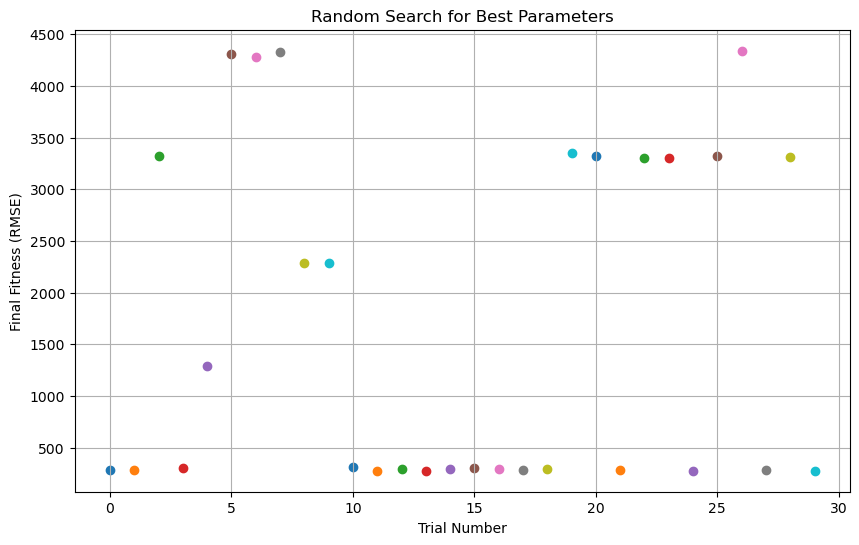

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device (with added random noise)
def add_random_error(sound_times):
    return sound_times + np.random.normal(0, 0.5, sound_times.shape)

sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])
sound_times_with_error = add_random_error(sound_times)

# Calculate distance between two points using latitude and longitude
def haversine_distance(lon1, lat1, lon2, lat2):
    delta_lon = (lon2 - lon1) * lon_conversion
    delta_lat = (lat2 - lat1) * lat_conversion
    return np.sqrt(delta_lon ** 2 + delta_lat ** 2)

# Calculate the time delay from each device to a potential explosion point using latitude and longitude
def time_delay(device, explosion_point, explosion_time):
    distance = haversine_distance(device[0], device[1], explosion_point[0], explosion_point[1])
    height_diff = abs(device[2] - explosion_point[2])
    total_distance = np.sqrt(distance ** 2 + height_diff ** 2)
    time_diff = total_distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution, sound_times):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0
    penalty = 0

    # Check the conditions for each explosion time
    for i in range(4):
        # Ensure explosion time is greater than zero
        if explosion_times[i] <= 0:
            penalty += 1000  # Large penalty for negative or zero times
        
        # Ensure explosion time is less than the minimum arrival time for each device
        for j in range(7):
            min_arrival_time = np.min(sound_times[j])
            if explosion_times[i] >= min_arrival_time:
                penalty += 1000  # Large penalty for exceeding the minimum arrival time

    # Calculate RMSE for the sound arrival times
    for i in range(7):  # For each device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(device_locations[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - sound_times[i, j]) ** 2  # Squared error
    
    # Add penalty if the time differences between explosions exceed 5 seconds
    for i in range(4):
        for j in range(i + 1, 4):
            if abs(explosion_times[i] - explosion_times[j]) > 5:
                penalty += 1000  # Arbitrary large penalty value for violation

    return np.sqrt(total_error) + penalty  # RMSE with penalty

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/height
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Evolve population function
def evolve_population(population, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness
    population = sorted(population, key=lambda x: fitness(x, sound_times_with_error))

    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]

    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate

    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population) // 2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])

        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)

        new_population.append(child)

    return new_population

# Particle Swarm Optimization
class Particle:
    def __init__(self, dimensions):
        self.position = np.random.uniform(1, 200, dimensions)
        self.velocity = np.random.uniform(-1, 1, dimensions)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

def particle_swarm_optimization(best_solution, num_particles=50, max_iterations=1000, w=0.5, c1=1.5, c2=1.5, sound_times_with_error=None):
    dimensions = len(best_solution)
    swarm = [Particle(dimensions) for _ in range(num_particles)]

    global_best_position = best_solution.copy()
    global_best_fitness = fitness(global_best_position, sound_times_with_error)

    fitness_history = [global_best_fitness]

    for iteration in range(max_iterations):
        for particle in swarm:
            # Update particle's fitness
            particle_fitness = fitness(particle.position, sound_times_with_error)

            # Update personal best
            if particle_fitness < particle.best_fitness:
                particle.best_position = particle.position.copy()
                particle.best_fitness = particle_fitness

            # Update global best
            if particle_fitness < global_best_fitness:
                global_best_position = particle.position.copy()
                global_best_fitness = particle_fitness

        fitness_history.append(global_best_fitness)

        for particle in swarm:
            # Update velocity
            particle.velocity = (
                w * particle.velocity +
                c1 * np.random.rand() * (particle.best_position - particle.position) +
                c2 * np.random.rand() * (global_best_position - particle.position)
            )

            # Update position
            particle.position += particle.velocity

        # Print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Best fitness: {global_best_fitness}")

    return global_best_position, fitness_history

# Genetic algorithm with elite preservation and PSO
def genetic_algorithm_with_pso_tracking(pop_size=300, generations=1000, elite_size=5, sound_times_with_error=None):
    population = generate_initial_population(pop_size)
    fitness_history = []

    for generation in range(generations):
        population = evolve_population(population, elite_size, generation, generations)

        # Track the best solution found
        best_solution = min(population, key=lambda x: fitness(x, sound_times_with_error))
        best_fitness = fitness(best_solution, sound_times_with_error)
        
        fitness_history.append(best_fitness)
        print(f"Generation {generation}: Best fitness = {best_fitness}")

        # If fitness is good enough, stop early
        if best_fitness < 100:
            break
    
    # After genetic algorithm finishes, perform PSO for local search
    best_solution, pso_fitness_history = particle_swarm_optimization(best_solution, sound_times_with_error=sound_times_with_error)
    
    return best_solution, fitness_history + pso_fitness_history

# Test the model with new synthetic data
def simulate_new_data():
    new_device_locations = np.array([
        [110.500, 27.600, 750],
        [110.600, 27.700, 760],
        [110.700, 27.800, 770],
        [110.800, 27.900, 780],
        [110.900, 28.000, 790],
        [111.000, 28.100, 800],
        [111.100, 28.200, 810]
    ])
    
    # Generate synthetic sound times based on new locations
    new_sound_times = np.random.uniform(50, 250, (7, 4)) + add_random_error(np.zeros((7, 4)))
    
    return new_device_locations, new_sound_times

# 参数网格定义
particle_options = [30, 50, 100]
iteration_options = [500, 1000, 1500]
w_options = [0.3, 0.5, 0.7]
c1_options = [1.0, 1.5, 2.0]
c2_options = [1.0, 1.5, 2.0]

# 随机搜索次数
num_trials = 30

# 记录最优结果
best_fitness_overall = float('inf')
best_params = None
results = []

# 随机搜索
new_device_locations, new_sound_times = simulate_new_data()

for trial in range(num_trials):
    num_particles = random.choice(particle_options)
    max_iterations = random.choice(iteration_options)
    w = random.choice(w_options)
    c1 = random.choice(c1_options)
    c2 = random.choice(c2_options)
    
    print(f"Testing: particles={num_particles}, iterations={max_iterations}, w={w}, c1={c1}, c2={c2}")
    
    # 运行算法
    best_solution, fitness_history = genetic_algorithm_with_pso_tracking(
        pop_size=100,
        generations=200,
        elite_size=5,
        sound_times_with_error=new_sound_times
    )
    
    # 记录结果
    final_fitness = fitness_history[-1]
    results.append((num_particles, max_iterations, w, c1, c2, final_fitness))
    
    # 更新最优参数
    if final_fitness < best_fitness_overall:
        best_fitness_overall = final_fitness
        best_params = (num_particles, max_iterations, w, c1, c2)

# 输出最优结果
print(f"Best Parameters: particles={best_params[0]}, iterations={best_params[1]}, w={best_params[2]}, c1={best_params[3]}, c2={best_params[4]}")
print(f"Best Fitness: {best_fitness_overall}")

# 可视化
results = np.array(results)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 绘制每次搜索的fitness结果
for i, (num_particles, max_iterations, w, c1, c2, fitness) in enumerate(results):
    ax.scatter(i, fitness, label=f"Particles={num_particles}, Iter={max_iterations}, w={w}, c1={c1}, c2={c2}")

ax.set_xlabel("Trial Number")
ax.set_ylabel("Final Fitness (RMSE)")
ax.set_title("Random Search for Best Parameters")
ax.grid(True)
plt.show()
